This notebook analysis the performance of the classifier in terms of response speed: i.e. how fast can the module identify a TDE with respect to its first observation and its peak.


In [1]:
from early_tde_classification.config import Config
import os
import pandas as pd
from astropy.table import Table

## 1. Load data

Let's get TNS indices.

In [2]:
import io
import requests

r = requests.post(
    'https://api.fink-portal.org/api/v1/resolver',
    json={
        'resolver': 'tns',
        'name': '',
        'nmax': 1000000
    }
)
tns = pd.read_json(io.BytesIO(r.content))
print(len(tns), 'TNS entries')

tns_tdes = tns[[_.startswith('TDE') and __.startswith('ZTF') for _,__ in zip(tns['d:type'], tns['d:internalname'])]]
tns_tdes = list(tns_tdes['d:internalname'].drop_duplicates().values.astype(str))
print(len(tns_tdes), 'TDEs')

tns_nontdes = tns[[not _.startswith('TDE') and _ != 'nan' and __.startswith('ZTF') for _,__ in zip(tns['d:type'], tns['d:internalname'])]]
tns_nontdes = list(tns_nontdes['d:internalname'].drop_duplicates().values.astype(str))
print(len(tns_nontdes), 'non-TDEs')

231434 TNS entries
106 TDEs
12628 non-TDEs


Let's load the lightcurves of the TDEs

In [3]:
from early_tde_classification.extract_features import load_extragalatic_data_full_lightcurves as load_lcs
Config.EXTRAGAL_FNAME = 'tde_objects_all_withupperlim_min5_1.parquet'

tde_lcs = load_lcs(object_list = tns_tdes)

And let's load the features

In [4]:

def post_fit_filtering(features):
    
    good_idx = features['r_chisq'] < 10    
    good_idx &= features['num_hist_detections'] < 1 # No detections in 100 days prior to the window
    good_idx &= features['num_prehist_negatives'] <= 1 # No negatives prior to the window
    
    good_idx &= features['e_reference_time'] < 100
    good_idx &= features['norm_rel_reference_time'] < 0 # 10
    good_idx &= features['norm_rel_reference_time'] > -10
    
    good_idx &= features['snr_rise_time'] > 1.5
    good_idx &= features['snr_T'] > 1.5
    
    # good0_idx = good_idx.copy()
    # good_idx &= features['pcounter'] == 0 # Only last sets of features for every peak

    features = features[good_idx]
    return features
    
feat_data = Table.read(os.path.join(Config.OUT_FEATURES_DIR, 'features_sergey_2025', 'features.all.pmulti.distnr.vot')).to_pandas()

# Filter 
feat_data = post_fit_filtering(feat_data)

# Get indices
tns_idx = np.isin(feat_data['objectId'], tns_nontdes + tns_tdes) # Everything in TNS
tdes_idx = np.isin(feat_data['objectId'], tns_tdes)

# Get only those with a TNS label
feat_data = feat_data[tns_idx]




In [5]:
# hammerstein_tdes = pd.read_csv(os.path.join(Config.INPUT_DIR, 'all_tde_in_ztf.csv'), dtype={'id': str}).objectId.unique().tolist()

# additional_tdes = [tde for tde in hammerstein_tdes if tde not in tns_tdes]
# found_tdes = [
#     "https://fink-portal.org/ZTF18aasvknh",
#     "https://fink-portal.org/ZTF20aamqmfk",
#     "https://fink-portal.org/ZTF20aazyvre",
#     "https://fink-portal.org/ZTF20abjwvae",
#     "https://fink-portal.org/ZTF20abrnwfc",
#     "https://fink-portal.org/ZTF21aazenvp",
#     "https://fink-portal.org/ZTF21abvydim",
#     "https://fink-portal.org/ZTF22aaizrty",
#     "https://fink-portal.org/ZTF23aajsmul",
#     "https://fink-portal.org/ZTF23abihmun",
#     "https://fink-portal.org/ZTF23abowyjf",
#     "https://fink-portal.org/ZTF23abprgop",
#     "https://fink-portal.org/ZTF24aaimfrw",
#     "https://fink-portal.org/ZTF24abwywkf",
#     "https://fink-portal.org/ZTF23aajnfna",
#     "https://fink-portal.org/ZTF21abvpudz",
#     "https://fink-portal.org/ZTF20abaeuwr",
#     "https://fink-portal.org/ZTF20abluzvg",
#     "https://fink-portal.org/ZTF21aagokfi",
#     "https://fink-portal.org/ZTF21acdpfwu",
#     "https://fink-portal.org/ZTF22aarvrcz",
#     "https://fink-portal.org/ZTF22aayyrvn",
#     "https://fink-portal.org/ZTF23abjvojy"
# ]
# for tde in additional_tdes:
#     print('https://fink-portal.org/'+tde)
#     if 'https://fink-portal.org/'+tde in found_tdes:
#         print('Found!')
# print(additional_tdes)

In [6]:
# Separate feature matrix and labels

def keep_only_features_for_classifier(feat_data):

    features_to_keep = ['e_reference_time', 'rise_time', 'snr_rise_time', 'T', 'r_chisq', 'distnr']
    return feat_data[features_to_keep]

feature_matrix = keep_only_features_for_classifier(feat_data).values

# Get labels as 'TDE' or 'nonTDE'
feat_data['tde_or_not'] = feat_data['objectId'].apply(
    lambda x: 'TDE' if x in tns_tdes else 'nonTDE')
# labels = feat_data['tde_or_not']
labels = feat_data['labels'] = feat_data['objectId'].isin(tns_tdes).astype(int)
tdes_sample_obj = feat_data[(feat_data.labels == True)].objectId.unique()

## 2. Proceed with XGBoost classifier with Leave-One-Out approach
Leave one out, train with the rest, and test on the one, for all of them.




In [7]:
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split, LeaveOneOut, cross_val_score, cross_validate, GridSearchCV, ParameterGrid, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



In [15]:
identified_dates = {}
fraction_of_rise_identified = {}
estimated_rise_time = {}
for test_obj in tdes_sample_obj:
	# Split test and train
	test_mask = feat_data['objectId'] == test_obj
	test_feat = feature_matrix[test_mask]
	test_labels = labels[test_mask]
	test_jds = feat_data.loc[test_mask, 'jd_max'].values

	# Training data: exclude test object and keep only last alert per object (pcounter == 0)
	train_mask = (feat_data['objectId'] != test_obj) & (feat_data['pcounter'] == 0)
	train_feat = feature_matrix[train_mask]
	train_labels = labels[train_mask]

	# Recompute pos_weight for training
	pos_weight = np.sum(train_labels == 0) / np.sum(train_labels == 1)

	# Initialize and fit classifier
	clf = xgb.XGBClassifier(n_estimators=100, scale_pos_weight=pos_weight, max_depth=3,
							subsample=0.2, learning_rate=0.01, reg_lambda=0.1, reg_alpha=5,
							min_child_weight=10, colsample_bytree=0.7, random_state=1)

	clf.fit(train_feat, train_labels)

	# Predict and evaluate
	y_pred = clf.predict(test_feat)

	# Store earliest detection date if any positive prediction
	if np.any(y_pred == 1):
		identif_jd = test_jds[y_pred == 1].min()
		identified_dates[test_obj] = identif_jd

        # Compute the fraction of the rise time at which it is identified
		tde_lc = tde_lcs[tde_lcs.objectId == test_obj].iloc[0]
		mask_no_upper_limits = np.isfinite(tde_lc.FLUXCAL)
		jd_detections = tde_lc.jd[mask_no_upper_limits]
		first_det_jd = np.min(jd_detections)
		peak_jd = jd_detections[np.argmax(tde_lc.FLUXCAL[mask_no_upper_limits])]
		if test_obj == 'ZTF20abwtifz':
			first_det_jd = sorted(jd_detections)[1]
        # Save values in dict
		estimated_rise_time[test_obj] = (peak_jd - first_det_jd)
		fraction_of_rise_identified[test_obj] = (identif_jd - first_det_jd) / (peak_jd - first_det_jd)

print('Number of TDEs detected: {}/{}'.format(len(fraction_of_rise_identified), len(tdes_sample_obj)))

Number of TDEs detected: 29/38


In [9]:
fraction_of_rise_identified

{'ZTF18aabuoxd': 1.0,
 'ZTF18abxnvoz': 0.4330951748230427,
 'ZTF20abisysx': 0.17614343622120082,
 'ZTF20abwtifz': 1.0,
 'ZTF20accxwrk': 0.5860359574591953,
 'ZTF20acitpfz': 0.4306734566945384,
 'ZTF20acnznms': 0.37299931782234746,
 'ZTF20acqoiyt': 0.8862115357246477,
 'ZTF21aaaokyp': 0.5478475199232619,
 'ZTF21aabiipy': 1.0630515237438702,
 'ZTF21aaeoitd': 1.0013272227731589,
 'ZTF21aakfqwq': 0.8698921952748355,
 'ZTF21aauuybx': 1.2041185084948238,
 'ZTF21abmwftm': 1.1198368625566166,
 'ZTF21abqhkjd': 0.48301795383513335,
 'ZTF21abqtckk': 1.166986408219384,
 'ZTF22aagvrlq': 1.1246117487483331,
 'ZTF22aavvqyh': 1.0,
 'ZTF23aapyidj': 0.48335372303756086,
 'ZTF23abohtqf': 0.8313325529476513,
 'ZTF24aaecooj': 0.46687358534435314,
 'ZTF24aajvvhj': 0.48052033156685336,
 'ZTF24aakaiha': 1.0,
 'ZTF24aaoxmyb': 0.454169579996493,
 'ZTF24aatxshz': 0.41914734848866925,
 'ZTF24abfaake': 1.9981291641233307,
 'ZTF24abmybnp': 0.58022109790422,
 'ZTF24abyhjvc': 0.7473676489452612,
 'ZTF25aafofcs': 0.70

## Analyse results and plot

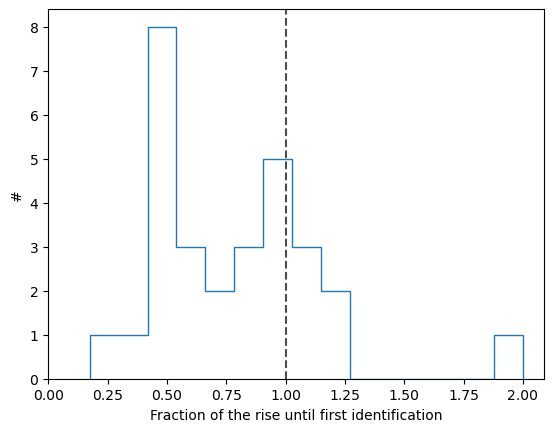

In [10]:
ax = plt.figure().gca()

ax.hist(list(fraction_of_rise_identified.values()), histtype = 'step', bins = 15)
ax.set_xlim(left =0)

ax.set_xlabel('Fraction of the rise until first identification')
ax.set_ylabel('#')
ax.axvline(1, color='black', linestyle='--', alpha=0.7)


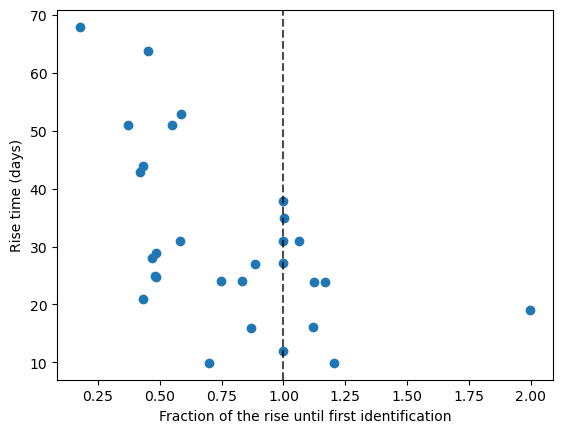

In [11]:
ax = plt.figure().gca()

ax.scatter(list(fraction_of_rise_identified.values()), list(estimated_rise_time.values()))
ax.set_xlabel('Fraction of the rise until first identification')
ax.set_ylabel('Rise time (days)')
ax.axvline(1, color='black', linestyle='--', alpha=0.7)


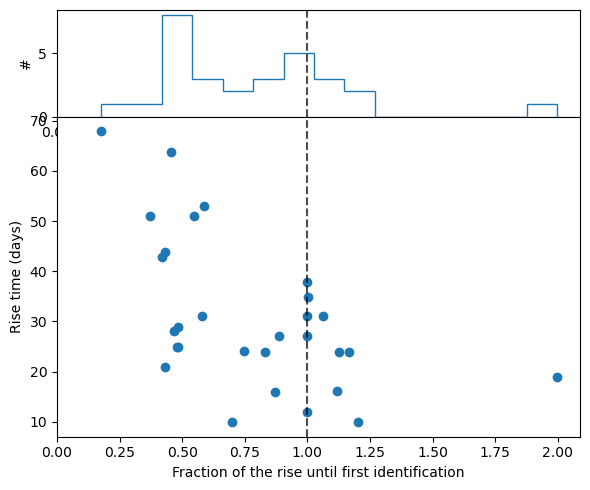

In [27]:
from matplotlib.gridspec import GridSpec
from scipy.stats import gaussian_kde
# Prepare data
x_vals = list(fraction_of_rise_identified.values())
y_vals = list(estimated_rise_time.values())

# Create figure and gridspec
fig = plt.figure(figsize=(6, 5))
gs = GridSpec(2, 1, height_ratios=[1, 3], hspace=0)  # Histogram smaller than scatter

# Histogram (top)
ax1 = fig.add_subplot(gs[0])
ax1.hist(x_vals, histtype='step', bins=15)
ax1.axvline(1, color='black', linestyle='--', alpha=0.7)
ax1.set_xlim(left=0)
ax1.set_ylabel('#')

# Scatter plot (bottom)
ax2 = fig.add_subplot(gs[1], sharex=ax1)
ax2.scatter(x_vals, y_vals)
ax2.axvline(1, color='black', linestyle='--', alpha=0.7)
ax2.set_xlim(left=0)
ax2.set_xlabel('Fraction of the rise until first identification')
ax2.set_ylabel('Rise time (days)')

plt.tight_layout()
# plt.savefig('Identification_speed_of_TNS_TDEs.pdf', format = 'pdf')

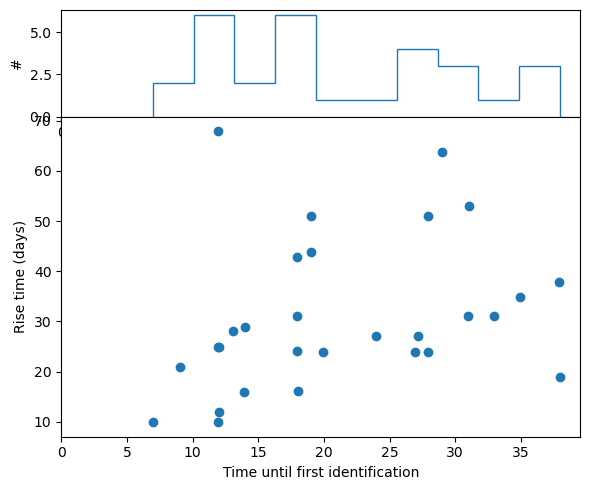

In [13]:
from matplotlib.gridspec import GridSpec

# Prepare data
x_vals = [fr *rt for fr,rt in zip(fraction_of_rise_identified.values(), estimated_rise_time.values())]
y_vals = list(estimated_rise_time.values())

# Create figure and gridspec
fig = plt.figure(figsize=(6, 5))
gs = GridSpec(2, 1, height_ratios=[1, 3], hspace=0)  # Histogram smaller than scatter

# Histogram (top)
ax1 = fig.add_subplot(gs[0])
ax1.hist(x_vals, histtype='step', bins=10)
# ax1.axvline(1, color='black', linestyle='--', alpha=0.7)
ax1.set_xlim(left=0)
ax1.set_ylabel('#')

# Scatter plot (bottom)
ax2 = fig.add_subplot(gs[1], sharex=ax1)
ax2.scatter(x_vals, y_vals)
# ax2.axvline(1, color='black', linestyle='--', alpha=0.7)
ax2.set_xlim(left=0)
ax2.set_xlabel('Time until first identification')
ax2.set_ylabel('Rise time (days)')

plt.tight_layout()
plt.show()
